# Pytorch预训练ImageNet-1000图像分类-摄像头实时画面

通过Python API方式，使用torchcam算法库，对Pytorch预训练ImageNet-1000图像分类模型进行基于CAM的可解释性分析。

同济子豪兄 https://space.bilibili.com/1900783

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

测试运行环境：Macbook Pro

2022-8-19

## 导入工具包

In [1]:
import os
import time

import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm # 进度条

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchcam.utils import overlay_mask
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


## 导入中文字体

In [2]:
# 下载中文字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [19]:
# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 50)

## 导入ImageNet预训练模型

In [5]:
from torchvision.models import resnet18
model = resnet18(pretrained=True).eval().to(device)

## 载入ImageNet 1000图像分类标签

ImageNet 1000类别中文释义：https://github.com/ningbonb/imagenet_classes_chinese

In [3]:
import pandas as pd
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
idx_to_labels_cn = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']
    idx_to_labels_cn[row['ID']] = row['Chinese']

## 导入可解释性分析方法

In [6]:
from torchcam.methods import SmoothGradCAMpp 
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = SmoothGradCAMpp(model)

## 预处理

In [7]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 获取摄像头的一帧画面

In [102]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

In [103]:
img_bgr.shape

(720, 1280, 3)

In [129]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [130]:
img_pil = Image.fromarray(img_rgb)

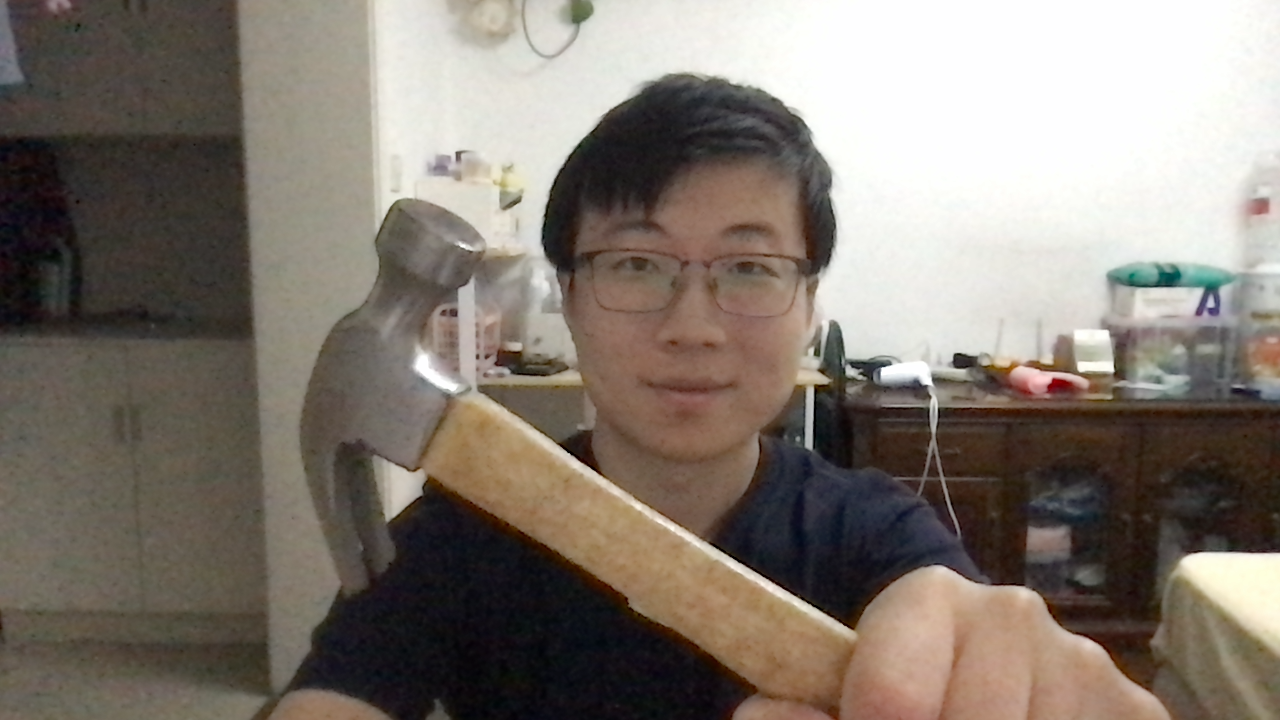

In [131]:
img_pil

ImageNet图像分类数据集中的一些常见类别及ID

手机 487, 605

书桌 526

锤子 587

笔记本电脑 681

遥控器 761

螺丝刀 784

太阳镜 836、837

卫生纸 999

In [132]:
# 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
show_class_id = 587
# show_class_id = None

# 是否显示中文类别
Chinese = True
# Chinese = False

In [137]:
# 前向预测
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_tensor)
pred_top1 = torch.topk(pred_logits, 1)
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()

In [138]:
# 可视化热力图的类别ID，如果不指定，则为置信度最高的预测类别ID
if show_class_id:
    show_id = show_class_id
else:
    show_id = pred_id
    show_class_id = pred_id

In [139]:
# 生成可解释性分析热力图（主要耗时部分）
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

In [141]:
# 在图像上写字
draw = ImageDraw.Draw(result)

if Chinese:
    # 在图像上写中文
    text_pred = 'Pred Class: {}'.format(idx_to_labels_cn[pred_id])
    text_show = 'Show Class: {}'.format(idx_to_labels_cn[show_class_id])
else:
    # 在图像上写英文
    text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_id])
    text_show = 'Show Class: {}'.format(idx_to_labels[show_class_id])
# 文字坐标，中文字符串，字体，rgba颜色
draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))

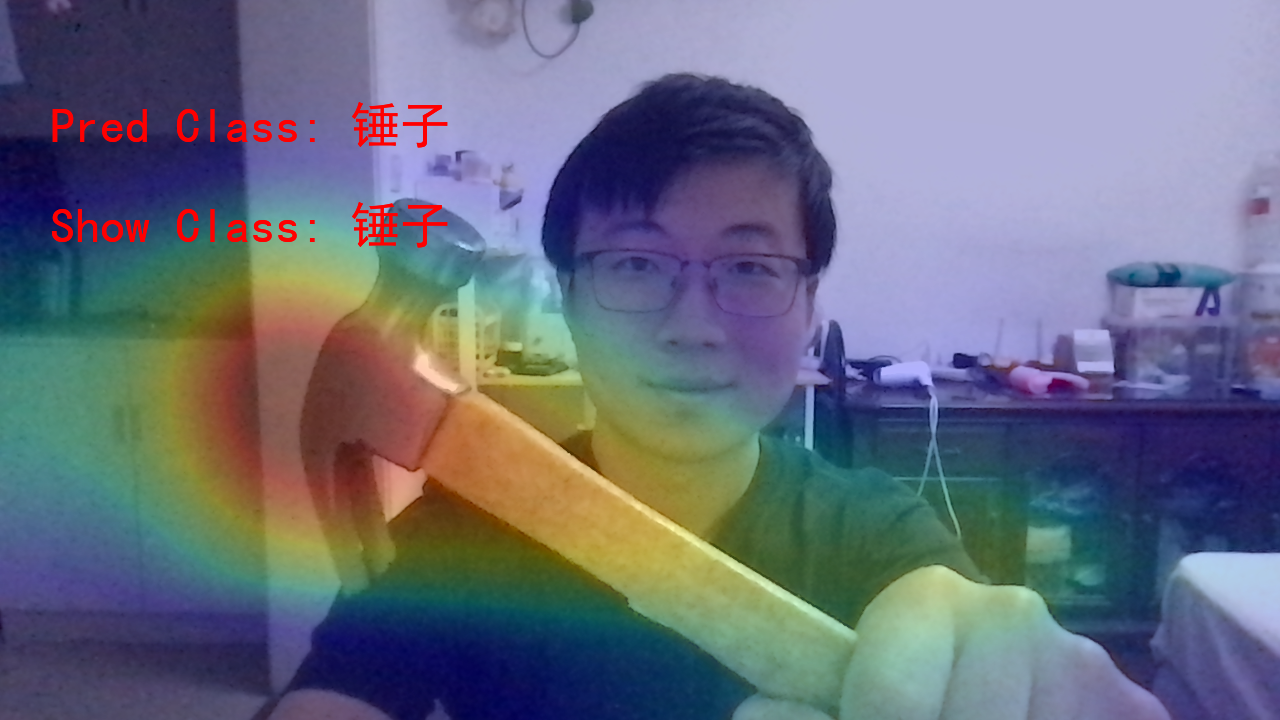

In [142]:
result

## 图像分类预测函数

In [119]:
def process_frame(img, show_class_id=None, Chinese=True):
    '''
    输入摄像头画面bgr-array和用于绘制热力图的类别ID，输出写字的热力图bgr-array
    如果不指定类别ID，则为置信度最高的预测类别ID
    '''
    
    img_bgr = img
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR 转 RGB
    img_pil = Image.fromarray(img_rgb) # array 转 pil
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_tensor) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_top1 = torch.topk(pred_logits, 1)
    pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()
    
    # 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
    if show_class_id:
        show_id = show_class_id
    else:
        show_id = pred_id
        show_class_id = pred_id
        
    # 生成可解释性分析热力图
    activation_map = cam_extractor(show_id, pred_logits)
    activation_map = activation_map[0][0].detach().cpu().numpy()
    result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)
    
    # 在图像上写字
    draw = ImageDraw.Draw(result)
    
    if Chinese:
        # 在图像上写中文
        text_pred = 'Pred Class: {}'.format(idx_to_labels_cn[pred_id])
        text_show = 'Show Class: {}'.format(idx_to_labels_cn[show_class_id])
    else:
        # 在图像上写英文
        text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_id])
        text_show = 'Show Class: {}'.format(idx_to_labels[show_class_id])
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
    draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))
        
    img_rgb = np.array(result)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    return img_bgr

## 调用摄像头获取每帧（模板）

In [144]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    # frame = process_frame(frame)
    frame = process_frame(frame, show_class_id=999) # 卫生纸
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 小练习

1.将类别设置为固定类别。

2.在家、校园、商场、饭店、公园、动物园里运行试试看。

3.用不同种类的狗、猫做测试。

4.用多个同类别物体（例如多个遥控器）做测试。

5.最耗时的是哪一部分？如何对实时预测做进一步加速？